In [ ]:
# ===============================================
# CLOINet SIMPLIFICADO - SOLO TÉRMINOS ORIGINALES DEL PAPER
# Sin términos nuevos en la función de pérdida
# ===============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import argparse
import pandas as pd
import os
import matplotlib.pyplot as plt

# ===============================================
# ARQUITECTURA MANTENIDA (sin cambios)
# ===============================================

class CluNet(nn.Module):
    """Clustering module - igual que antes"""
    def __init__(self, input_channels, num_clusters=20, hidden_channels=[8, 16]):
        super(CluNet, self).__init__()
        self.num_clusters = num_clusters
        
        # CNN layers para extracción de características
        self.conv1 = nn.Conv2d(input_channels, hidden_channels[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels[0], hidden_channels[1], kernel_size=3, padding=1)
      
               
        # Final layer para cluster membership
        self.cluster_conv = nn.Conv2d(hidden_channels[1], num_clusters, kernel_size=1)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(hidden_channels[0])
        self.bn2 = nn.BatchNorm2d(hidden_channels[1])
        self.bn3 = nn.BatchNorm2d(num_clusters)
        
        # Dropout para regularización
        self.dropout = nn.Dropout2d(p=0.1)
        
    def forward(self, x):
        # Verificación de dimensiones
        if len(x.shape) != 4:
            raise RuntimeError(f"CluNet expects 4D input [batch, channels, H, W], got {x.shape}")
        
        # CNN feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        # Cluster memberships con softmax
        cluster_memberships = F.softmax(self.cluster_conv(x), dim=1)
        
        return cluster_memberships

class UnsupervisedOINet(nn.Module):
    """OI Neural Network - simplificado sin consistencia espacial extra"""
    def __init__(self, num_priors=4):
        super(UnsupervisedOINet, self).__init__()
        self.num_priors = num_priors
        
        # CNN para unificación de campos
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 1, kernel_size=3, padding=1)
        
        # Red para estimación de longitudes de correlación
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)  # 3 correlation lengths
        
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(1)
        
    def forward(self, observations, observation_mask):
        # Verificar dimensiones de entrada
        if len(observations.shape) != 4:
            raise RuntimeError(f"OINet expects 4D input [batch, channels, H, W], got {observations.shape}")
        
        # Procesamiento CNN
        x = F.relu(self.bn1(self.conv1(observations)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        
        # Manejar batch size = 1
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        
        # Red feedforward
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        correlation_lengths = F.softplus(self.fc3(x))
        
        # Generar múltiples priores con diferentes escalas
        priors = []
        for i in range(self.num_priors):
            scale = (i + 1) * 0.5
            scaled_lengths = correlation_lengths * scale
            
            # Aplicar OI básico (sin términos extra)
            prior = self.apply_basic_optimal_interpolation(
                observations, observation_mask, scaled_lengths
            )
            priors.append(prior)
        
        return torch.stack(priors, dim=1).squeeze(2)  # [batch, num_priors, H, W]
    
    def apply_basic_optimal_interpolation(self, observations, mask, correlation_lengths):
        """OI básico sin módulos de consistencia adicionales"""
        batch_size = observations.size(0)
        
        interpolated_batch = []
        
        for b in range(batch_size):
            # Kernel gaussiano simple
            sigma = torch.clamp(correlation_lengths[b, 0] / 3.0, min=0.5, max=5.0)
            kernel = self.gaussian_kernel(7, sigma.item())
            kernel = kernel.to(observations.device).unsqueeze(0).unsqueeze(0)
            
            # Interpolación básica
            interpolated = F.conv2d(observations[b:b+1], kernel, padding=3)
            interpolated_batch.append(interpolated)
        
        return torch.cat(interpolated_batch, dim=0)
    
    def gaussian_kernel(self, size, sigma):
        """Crear kernel gaussiano"""
        coords = torch.arange(size, dtype=torch.float)
        coords -= size // 2
        g = coords**2
        g = (-g / (2.0 * sigma**2)).exp()
        g /= g.sum()
        return g.outer(g)

class ReNet(nn.Module):
    """Refinement Network - simplificado"""
    def __init__(self, num_clusters=20):
        super(ReNet, self).__init__()
        self.num_clusters = num_clusters
        
        # Fusión simple sin attention
        self.fusion_conv = nn.Conv2d(num_clusters * 2, num_clusters * 2, kernel_size=3, padding=1)
        self.attention_conv = nn.Conv2d(num_clusters * 2, num_clusters, kernel_size=1)
        self.refinement_conv = nn.Conv2d(num_clusters, num_clusters, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_clusters * 2)
        self.bn2 = nn.BatchNorm2d(num_clusters)
        
    def forward(self, surface_clusters, observation_clusters):
        # Concatenar clusters
        combined = torch.cat([surface_clusters, observation_clusters], dim=1)
        
        # Fusión
        fused = F.relu(self.bn1(self.fusion_conv(combined)))
        reduced = F.relu(self.attention_conv(fused))
        refined = F.softmax(self.bn2(self.refinement_conv(reduced)), dim=1)
        
        return refined

class OriginalCLOINet(nn.Module):
    """
    CLOINet ORIGINAL - Solo con términos del paper original
    Sin términos adicionales no supervisados
    """
    def __init__(self, num_depths=3, num_clusters=20, image_size=(128, 128)):
        super(OriginalCLOINet, self).__init__()
        self.num_depths = num_depths
        self.num_clusters = num_clusters
        self.image_size = image_size
        
        # Módulos principales (sin cambios)
        self.surface_clunet = CluNet(input_channels=1, num_clusters=num_clusters)
        self.unsupervised_oinet = UnsupervisedOINet(num_priors=4)
        self.obs_clunet = CluNet(input_channels=4, num_clusters=num_clusters)
        
        # Modules de fusión para cada profundidad
        self.renets = nn.ModuleList([
            ReNet(num_clusters=num_clusters) for _ in range(num_depths)
        ])
        
        # SIMPLIFICADO: Decoder básico
        self.decoder = nn.Sequential(
            nn.Conv2d(num_clusters, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, num_depths, kernel_size=1)
        )
        
    def forward(self, magnetometry_data, magnetometry_mask, gravimetry_data=None):
        """Forward pass simplificado"""
        
        # Corrección de dimensiones si es necesario
        if len(magnetometry_data.shape) == 5:
            batch_size = magnetometry_data.shape[0] * magnetometry_data.shape[1]
            magnetometry_data = magnetometry_data.view(batch_size, 
                                                     magnetometry_data.shape[2],
                                                     magnetometry_data.shape[3],
                                                     magnetometry_data.shape[4])
            magnetometry_mask = magnetometry_mask.view(batch_size,
                                                     magnetometry_mask.shape[2],
                                                     magnetometry_mask.shape[3], 
                                                     magnetometry_mask.shape[4])
            if gravimetry_data is not None:
                gravimetry_data = gravimetry_data.view(batch_size,
                                                     gravimetry_data.shape[2],
                                                     gravimetry_data.shape[3],
                                                     gravimetry_data.shape[4])
        
        batch_size = magnetometry_data.size(0)
        
        # Crear tensor de gravimetría si no existe
        if gravimetry_data is None:
            gravimetry_data = torch.zeros_like(magnetometry_data)
        
        # Procesar campos superficiales (gravimetría = zeros)
        surface_clusters = self.surface_clunet(gravimetry_data)
        
        # Procesar observaciones in-situ (magnetometría)
        observation_priors = self.unsupervised_oinet(magnetometry_data, magnetometry_mask)
        observation_clusters = self.obs_clunet(observation_priors)
        
        # Fusión y reconstrucción para cada profundidad
        reconstructions = []
        refined_clusters_list = []
        
        for i, renet in enumerate(self.renets):
            refined_clusters = renet(surface_clusters, observation_clusters)
            refined_clusters_list.append(refined_clusters)


            # USAR MÉTODO EFICIENTE EN MEMORIA
            covariance, (H_cov, W_cov) = self.compute_cluster_covariance(
                refined_clusters, target_size=64
            )
            
            # OI con resolución ajustada
            reconstruction = self.basic_cluster_optimal_interpolation(
                magnetometry_data, magnetometry_mask, covariance, 
                refined_clusters, (H_cov, W_cov)
            )
            
            reconstructions.append(reconstruction)
            
            # Cálculo de covarianza básico (del paper original)
            #covariance = self.compute_cluster_covariance(refined_clusters)
            
            # OI en espacio de clusters (básico)
            #reconstruction = self.basic_cluster_optimal_interpolation(
            #    magnetometry_data, magnetometry_mask, covariance, refined_clusters
            #)
            
            #reconstructions.append(reconstruction)
        
        # Stack de reconstrucciones
        stacked_reconstructions = torch.stack(reconstructions, dim=1)
        
        # Decodificación final
        final_clusters = refined_clusters_list[-1]
        decoded_reconstruction = self.decoder(final_clusters)
        
        return {
            'reconstruction': decoded_reconstruction,
            'stacked_reconstructions': stacked_reconstructions,
            'surface_clusters': surface_clusters,
            'observation_clusters': observation_clusters,
            'refined_clusters': final_clusters,
            'observation_priors': observation_priors
        }
    
    #def compute_cluster_covariance(self, cluster_memberships):
        """
        Cálculo de covarianza original del paper - ECUACIÓN 9
        B_i,j = 1 - sum_k (m'_ik - m'_jk)^2
        """
    #    batch_size, num_clusters, H, W = cluster_memberships.shape
    #    memberships = cluster_memberships.view(batch_size, num_clusters, H * W)
        
        # Computar diferencias en vectores de membresía
    #    memberships_t = memberships.transpose(1, 2)  # [batch, H*W, num_clusters]
    #    diff = memberships_t.unsqueeze(2) - memberships_t.unsqueeze(1)  # [batch, H*W, H*W, num_clusters]
        
        # Covarianza original: 1 - sum de diferencias cuadradas
    #    covariance = 1.0 - torch.sum(diff ** 2, dim=-1)  # [batch, H*W, H*W]
        
    #    return covariance
    


    def compute_cluster_covariance(self, cluster_memberships, 
                                     target_size=64):
        """
        SOLUCIÓN HÍBRIDA RECOMENDADA:
        1. Downsample a 64x64 (reduce 4x)
        2. Procesar batch por batch
        3. Usar sparse para puntos lejanos
        """
        batch_size, num_clusters, H, W = cluster_memberships.shape
        
        # PASO 1: Reducir resolución
        if H > target_size or W > target_size:
            cluster_downsampled = F.interpolate(
                cluster_memberships, 
                size=(target_size, target_size), 
                mode='bilinear', 
                align_corners=False
            )
            H_work, W_work = target_size, target_size
        else:
            cluster_downsampled = cluster_memberships
            H_work, W_work = H, W
        
        N_work = H_work * W_work
        
        memberships = cluster_downsampled.view(batch_size, num_clusters, N_work)
        memberships_t = memberships.transpose(1, 2)  # [batch, N_work, num_clusters]
        
        # PASO 2: Procesar batch por batch
        covariance_list = []
        
        for b in range(batch_size):
            mem_b = memberships_t[b]  # [N_work, num_clusters]
            
            # PASO 3: Cálculo eficiente por bloques pequeños
            block_size = 512  # Ajustar según memoria disponible
            num_blocks = (N_work + block_size - 1) // block_size
            
            covariance_b = torch.zeros(N_work, N_work, device=cluster_memberships.device)
            
            for i in range(num_blocks):
                start_i = i * block_size
                end_i = min((i + 1) * block_size, N_work)
                
                # Calcular fila completa de covarianza por bloque
                mem_i = mem_b[start_i:end_i]  # [block_size, num_clusters]
                
                # Diferencia con todos los puntos
                diff = mem_i.unsqueeze(1) - mem_b.unsqueeze(0)  # [block_size, N_work, num_clusters]
                cov_row = 1.0 - torch.sum(diff ** 2, dim=-1)  # [block_size, N_work]
                
                covariance_b[start_i:end_i, :] = cov_row
                
                # Liberar memoria
                del diff, cov_row
            
            covariance_list.append(covariance_b)
        
        covariance = torch.stack(covariance_list, dim=0)
        
        return covariance, (H_work, W_work)

    
    def basic_cluster_optimal_interpolation(self, observations, mask, covariance, clusters):
        """OI básico en espacio de clusters - del paper original"""
        batch_size, _, H, W = observations.shape
        
        obs_flat = observations.view(batch_size, H * W)
        mask_flat = mask.view(batch_size, H * W)
        
        # Observaciones con máscara
        masked_obs = obs_flat * mask_flat
        
        # OI básico
        interpolated = torch.bmm(covariance, masked_obs.unsqueeze(-1)).squeeze(-1)
        
        # Normalización básica
        normalization = torch.bmm(covariance, mask_flat.unsqueeze(-1)).squeeze(-1)
        interpolated = interpolated / (normalization + 1e-8)
        
        result = interpolated.view(batch_size, 1, H, W)
        return result

# ===============================================
# FUNCIÓN DE PÉRDIDA ORIGINAL SIMPLIFICADA
# Solo términos del paper original, sin supervisión
# ===============================================

class OriginalRobustFuzzyCMeansLoss(nn.Module):
    """
    Pérdida Robust Fuzzy C-means ORIGINAL del paper
    Ecuación 7: L_RFCM = Σ m_jk^q |y_j - v_k|^2 + b * Σ smoothness
    """
    def __init__(self, q=2.0, b=1.0):
        super(OriginalRobustFuzzyCMeansLoss, self).__init__()
        self.q = q  # Parámetro de fuzziness
        self.b = b  # Peso de suavidad espacial
        
    def forward(self, memberships, input_field):
        batch_size, num_clusters, H, W = memberships.shape
        
        # Calcular centros de cluster (Ecuación 8)
        centers = self.compute_centers(memberships, input_field)
        
        # TÉRMINO 1: Distancia ponderada a centros
        term1 = 0.0
        for k in range(num_clusters):
            membership_k = memberships[:, k:k+1, :, :]  # [batch, 1, H, W]
            center_k = centers[:, k:k+1, :, :].expand_as(input_field)
            
            distance_sq = (input_field - center_k) ** 2
            weighted_distance = (membership_k ** self.q) * distance_sq
            term1 += weighted_distance.sum()
        
        # TÉRMINO 2: Suavidad espacial original
        term2 = 0.0
        for k in range(num_clusters):
            membership_k = memberships[:, k, :, :]  # [batch, H, W]
            
            # Gradientes espaciales simples
            if H > 1:
                grad_y = membership_k[:, 1:, :] - membership_k[:, :-1, :]
                term2 += (grad_y ** 2).sum()
            
            if W > 1:
                grad_x = membership_k[:, :, 1:] - membership_k[:, :, :-1]
                term2 += (grad_x ** 2).sum()
        
        return term1 + self.b * term2
    
    def compute_centers(self, memberships, input_field):
        """
        Calcular centros de clusters (Ecuación 8 del paper)
        v_k = Σ(m_jk^q * y_j) / Σ(m_jk^q)
        """
        batch_size, num_clusters, H, W = memberships.shape
        centers = torch.zeros(batch_size, num_clusters, 1, 1, device=memberships.device)
        
        for k in range(num_clusters):
            membership_k = memberships[:, k:k+1, :, :]  # [batch, 1, H, W]
            weighted_sum = (membership_k ** self.q * input_field).sum(dim=[2, 3], keepdim=True)
            weight_sum = (membership_k ** self.q).sum(dim=[2, 3], keepdim=True)
            centers[:, k:k+1, :, :] = weighted_sum / (weight_sum + 1e-8)
        
        return centers

class OriginalCLOINetLoss(nn.Module):
    """
    Función de pérdida ORIGINAL del paper CLOINet
    Ecuación 10: L = α*L_RFCM^surf + β*L_RFCM^obs 
    
    SIN términos supervisados (no hay ground truth)
    SIN términos adicionales no supervisados
    """
    def __init__(self, alpha=1.0, beta=1.0):
        super(OriginalCLOINetLoss, self).__init__()
        self.alpha = alpha  # Peso clustering superficial
        self.beta = beta    # Peso clustering observaciones
        
        self.rfcm_loss = OriginalRobustFuzzyCMeansLoss(q=2.0, b=1.0)
        
    def forward(self, model_output, magnetometry_data, magnetometry_mask, gravimetry_data):
        """
        Función de pérdida original simplificada
        Solo dos términos de clustering auto-supervisado
        """
        
        # Extraer outputs del modelo
        surface_clusters = model_output['surface_clusters'] 
        obs_clusters = model_output['observation_clusters']
        observation_priors = model_output['observation_priors']
        
        # 1. PÉRDIDA DE CLUSTERING SUPERFICIAL (gravimetría = zeros)
        surface_rfcm_loss = self.rfcm_loss(surface_clusters, gravimetry_data)
        
        # 2. PÉRDIDA DE CLUSTERING OBSERVACIONES (magnetometría)
        # Usar promedio de priores como campo de entrada
        obs_field = observation_priors.mean(dim=1, keepdim=True)  # [batch, 1, H, W]
        obs_rfcm_loss = self.rfcm_loss(obs_clusters, obs_field)
        
        # PÉRDIDA TOTAL ORIGINAL
        total_loss = self.alpha * surface_rfcm_loss + self.beta * obs_rfcm_loss
        
        return total_loss, {
            'surface_rfcm_loss': surface_rfcm_loss.item(),
            'obs_rfcm_loss': obs_rfcm_loss.item(),
            'total_loss': total_loss.item()
        }



In [2]:
class MagnetometryDataProcessor:
    """
    Procesa datos scattered de magnetometría para CLOINet no supervisado
    """
    def __init__(self, grid_size=(128, 128)):
        self.grid_size = grid_size
        
    def process_magnetometry_data(self, x_coords, y_coords, z_values, normalize=True):
        """
        Convierte datos scattered a formato CLOINet
        
        Args:
            x_coords: df_magnetometry["Este"].values
            y_coords: df_magnetometry["Norte"].values  
            z_values: df_magnetometry["Anomalia_Magnetica_Campo_Total"].values
        """
        
        H, W = self.grid_size
        
        # 1. CREAR GRILLA REGULAR
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        # Grilla regular para CLOINet
        grid_x, grid_y = np.mgrid[x_min:x_max:complex(W), y_min:y_max:complex(H)]
        
        # 2. MAPEAR OBSERVACIONES A GRILLA
        # Convertir coordenadas a índices de grilla
        x_indices = ((x_coords - x_min) / (x_max - x_min) * (W - 1)).astype(int)
        y_indices = ((y_coords - y_min) / (y_max - y_min) * (H - 1)).astype(int)
        
        # Crear máscara y datos espársos
        observation_mask = np.zeros((1, 1, H, W), dtype=np.float32)
        observation_data = np.zeros((1, 1, H, W), dtype=np.float32)
        
        # Colocar observaciones en grilla
        for i in range(len(x_coords)):
            if 0 <= y_indices[i] < H and 0 <= x_indices[i] < W:
                observation_mask[0, 0, y_indices[i], x_indices[i]] = 1.0
                observation_data[0, 0, y_indices[i], x_indices[i]] = z_values[i]
        
        # 3. NORMALIZACIÓN (importante para convergencia)
        if normalize:
            z_mean = np.mean(z_values)
            z_std = np.std(z_values)
            observation_data = (observation_data - z_mean) / (z_std + 1e-8)
        else:
            z_mean, z_std = 0, 1
            
        # 4. TENSOR DE GRAVIMETRÍA (zeros como especificaste)
        gravimetry_data = np.zeros_like(observation_data)
        
        # 5. CONVERSIÓN A TENSORES PYTORCH
        magnetometry_tensor = torch.from_numpy(observation_data).float()
        magnetometry_mask_tensor = torch.from_numpy(observation_mask).float()
        gravimetry_tensor = torch.from_numpy(gravimetry_data).float()
        
        return {
            'magnetometry_data': magnetometry_tensor,
            'magnetometry_mask': magnetometry_mask_tensor, 
            'gravimetry_data': gravimetry_tensor,
            'metadata': {
                'x_min': x_min, 'x_max': x_max,
                'y_min': y_min, 'y_max': y_max,
                'z_mean': z_mean, 'z_std': z_std,
                'num_observations': len(x_coords)
            }
        }

def adapt_your_magnetometry_data(df_magnetometry, grid_size=(128, 128)):
    """
    FUNCIÓN PRINCIPAL para adaptar exactamente tus datos
    """
    print("=== ADAPTANDO TUS DATOS DE MAGNETOMETRÍA ===")
    
    # Extraer tus datos exactamente como los tienes
    x_magn = df_magnetometry["Este"].values
    y_magn = df_magnetometry["Norte"].values
    z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values
    
    print(f"Datos originales: {len(x_magn)} observaciones")
    print(f"Rango Este: [{x_magn.min():.0f}, {x_magn.max():.0f}]")
    print(f"Rango Norte: [{y_magn.min():.0f}, {y_magn.max():.0f}]")
    print(f"Rango Anomalía: [{z_magn.min():.2f}, {z_magn.max():.2f}]")
    
    # Procesar con CLOINet format
    processor = MagnetometryDataProcessor(grid_size=grid_size)
    processed_data = processor.process_magnetometry_data(x_magn, y_magn, z_magn)
    
    print(f"Datos procesados:")
    print(f"  Magnetometría: {processed_data['magnetometry_data'].shape}")
    print(f"  Máscara: {processed_data['magnetometry_mask'].shape}") 
    print(f"  Gravimetría: {processed_data['gravimetry_data'].shape}")
    print(f"  Observaciones en grilla: {torch.sum(processed_data['magnetometry_mask'])}")
    
    return processed_data

def create_cloi_batches(processed_data, batch_size=4):
    """
    Crear batches para entrenamiento CLOINet
    """
    # Expandir a múltiples muestras en el batch
    mag_data = processed_data['magnetometry_data'].repeat(batch_size, 1, 1, 1)
    mag_mask = processed_data['magnetometry_mask'].repeat(batch_size, 1, 1, 1)
    grav_data = processed_data['gravimetry_data'].repeat(batch_size, 1, 1, 1)
    
    # Añadir variabilidad a cada muestra del batch
    for i in range(1, batch_size):
        # Subsampling aleatorio de observaciones para cada muestra
        mask_sample = mag_mask[i].clone()
        obs_positions = torch.where(mask_sample[0] > 0.5)
        
        if len(obs_positions[0]) > 10:
            # Mantener solo un subconjunto aleatorio de observaciones
            num_keep = int(0.7 * len(obs_positions[0]))  # Mantener 70%
            keep_indices = torch.randperm(len(obs_positions[0]))[:num_keep]
            
            # Crear nueva máscara
            new_mask = torch.zeros_like(mask_sample)
            new_mask[0, obs_positions[0][keep_indices], obs_positions[1][keep_indices]] = 1.0
            
            mag_mask[i] = new_mask
            mag_data[i] = mag_data[i] * new_mask
    
    return mag_data, mag_mask, grav_data

def reconstruct_to_original_coords(model_output, processed_data):
    """
    Reconstruir predicciones de vuelta a coordenadas originales
    """
    metadata = processed_data['metadata']
    
    # Extraer reconstrucción del modelo
    reconstruction = model_output['reconstruction']  # [batch, depths, H, W]
    
    if len(reconstruction.shape) == 4:
        # Tomar primera muestra y primera profundidad
        recon_field = reconstruction[0, 0].detach().cpu().numpy()
    else:
        recon_field = reconstruction[0].detach().cpu().numpy()
    
    H, W = recon_field.shape
    
    # Crear coordenadas de grilla
    x_grid = np.linspace(metadata['x_min'], metadata['x_max'], W)
    y_grid = np.linspace(metadata['y_min'], metadata['y_max'], H)
    
    # Desnormalizar
    recon_field_denorm = recon_field * metadata['z_std'] + metadata['z_mean']
    
    return {
        'x_grid': x_grid,
        'y_grid': y_grid, 
        'reconstruction_grid': recon_field_denorm,
        'reconstruction_normalized': recon_field
    }


In [3]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
parser.add_argument('--gravimetry_folder', default='Datos_Gravimetria_Anomalia_Residual', type=str, help='Folder path to gravimetry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")
gravimetry_path = os.path.join(args.data_folder, args.gravimetry_folder, "Puntos_Grilla_Anomalia_Residual_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)
df_gravimetry = pd.read_excel(gravimetry_path)

In [4]:
# PASO 1: Cargar tus datos (como ya los tienes)
x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

# PASO 2: Adaptar al formato CLOINet
processed_data = adapt_your_magnetometry_data(df_magnetometry, grid_size=(128, 128))

# PASO 3: Crear batches para entrenamiento
mag_data, mag_mask, grav_data = create_cloi_batches(processed_data, batch_size=1)

# PASO 4: Usar con CLOINet no supervisado
model = OriginalCLOINet(num_depths=3, num_clusters=20, image_size=(128, 128))
criterion = OriginalCLOINetLoss()

=== ADAPTANDO TUS DATOS DE MAGNETOMETRÍA ===
Datos originales: 1465 observaciones
Rango Este: [4730159, 4741202]
Rango Norte: [2048740, 2058832]
Rango Anomalía: [-1043.36, 1149.06]
Datos procesados:
  Magnetometría: torch.Size([1, 1, 128, 128])
  Máscara: torch.Size([1, 1, 128, 128])
  Gravimetría: torch.Size([1, 1, 128, 128])
  Observaciones en grilla: 1465.0


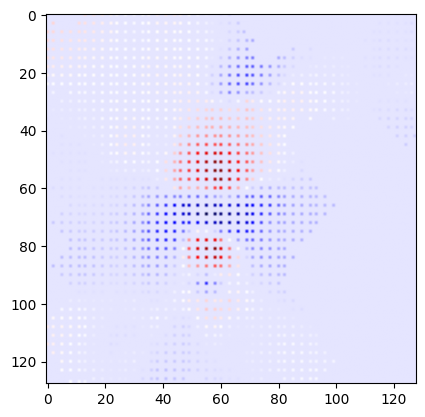

In [5]:
plt.imshow(mag_data[0,0].numpy(), cmap="seismic")
plt.show()

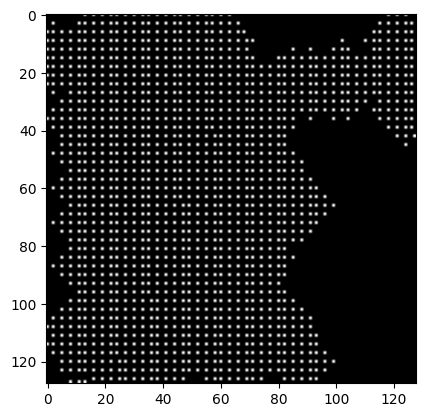

In [6]:
plt.imshow(mag_mask[0,0].numpy(), cmap="gray")
plt.show()

In [7]:
# Forward pass
model_output = model(mag_data, mag_mask, grav_data)

# Calcular pérdida no supervisada
loss, loss_dict = criterion(model_output, mag_data, mag_mask, grav_data)

print("Pérdidas no supervisadas:")
for key, value in loss_dict.items():
    print(f"  {key}: {value:.6f}")

# PASO 5: Reconstruir a coordenadas originales
reconstruction_result = reconstruct_to_original_coords(model_output, processed_data)

print(f"Reconstrucción completada:")
print(f"  Grilla X: {reconstruction_result['x_grid'].shape}")
print(f"  Grilla Y: {reconstruction_result['y_grid'].shape}")
print(f"  Campo reconstruido: {reconstruction_result['reconstruction_grid'].shape}")

TypeError: OriginalCLOINet.basic_cluster_optimal_interpolation() takes 5 positional arguments but 6 were given